/Users/veronicaage/miniconda3/envs/rasterio_env/lib/python3.10/site-packages/rasterio/merge.py:363: UserWarning: Ignoring nodata value. The nodata value, -3.4028230607370965e+38, cannot safely be represented in the chosen data type, float32. Consider overriding it using the --nodata option for better results. Falling back to first source's nodata value.
  warnings.warn(


Slopes saved to: /Users/veronicaage/Downloads/mora-das-slope-1000m.csv


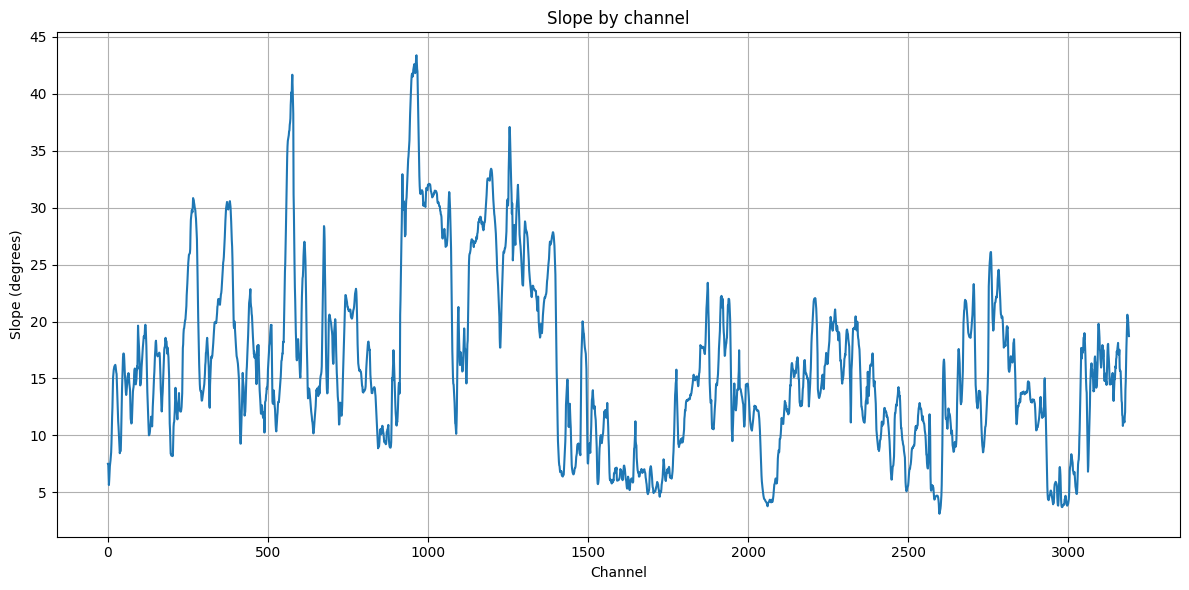

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.merge import merge
from rasterio.transform import rowcol
from pyproj import Transformer
import pandas as pd
from glob import glob

# --- 1) Input parameters ---
tif_folder = '/Users/veronicaage/Downloads/datasetsA/rainier_2007/dtm'   # folder containing your .tif files
csv_path   = '/Users/veronicaage/Downloads/mora-das.csv'                 # CSV with columns Channel, Latitude [°], Longitude [°]
buffer_m   = 100  # buffer in meters around the points

# --- 2) Read and clean the CSV ---
df = pd.read_csv(csv_path)
df = df.dropna(subset=['Channel', 'Latitude [°]', 'Longitude [°]'], how='any')

# --- 3) Project GPS coordinates to EPSG:2927 ---
transformer = Transformer.from_crs("EPSG:4326", "EPSG:2927", always_xy=True)
x_pts, y_pts = transformer.transform(df['Longitude [°]'].values,
                                     df['Latitude [°]'].values)

# --- 4) Create bounding box with buffer ---
minx, maxx = x_pts.min() - buffer_m, x_pts.max() + buffer_m
miny, maxy = y_pts.min() - buffer_m, y_pts.max() + buffer_m

# --- 5) Open and filter only tiles that intersect the bounding box ---
tif_files = glob(f"{tif_folder}/*.tif")
src_files = [rasterio.open(fp) for fp in tif_files]
overlapping = []
for src in src_files:
    left, bottom, right, top = src.bounds
    if not (right < minx or left > maxx or top < miny or bottom > maxy):
        overlapping.append(src)
if not overlapping:
    raise RuntimeError("No DTM tile intersects the area of interest.")

# --- 6) Merge only the intersecting region (at native resolution) ---
res_x = abs(overlapping[0].transform.a)
res_y = abs(overlapping[0].transform.e)
mosaic, out_trans = merge(
    overlapping,
    method='max',
    bounds=(minx, miny, maxx, maxy),
    res=(res_x, res_y)
)

# Close all datasets
for src in src_files:
    src.close()

# --- 7) Function to compute slope in degrees ---
def compute_slope(dem, transform):
    dx = abs(transform.a)
    dy = abs(transform.e)
    dz_dx = np.gradient(dem, axis=1) / dx
    dz_dy = np.gradient(dem, axis=0) / dy
    slope_rad = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
    return np.degrees(slope_rad)

# --- 8) Compute slope from the cropped DEM ---
dem_crop   = mosaic[0]
slope_crop = compute_slope(dem_crop, out_trans)

# --- 9) Sample slope at each GPS point ---
r# Convert projected coordinates to row/column indices
rows, cols = rowcol(out_trans, x_pts, y_pts)

# Initialize output array with NaN
slope_pts = np.full(len(x_pts), np.nan, dtype=float)

# Get slope map dimensions
h, w = slope_crop.shape

# Convert buffer size in meters to number of pixels (in X and Y)
res_x = abs(out_trans.a)  # pixel width in meters
res_y = abs(out_trans.e)  # pixel height in meters (usually negative, so use abs)
buffer_px_x = int(buffer_m / res_x)
buffer_px_y = int(buffer_m / res_y)

# Loop through each point and sample average slope in the surrounding window
for i, (r, c) in enumerate(zip(rows, cols)):
    # Define window bounds around the point, clipped to valid indices
    r0 = max(r - buffer_px_y, 0)
    r1 = min(r + buffer_px_y + 1, h)
    c0 = max(c - buffer_px_x, 0)
    c1 = min(c + buffer_px_x + 1, w)
    
    # Extract the slope values within the window
    window = slope_crop[r0:r1, c0:c1]

    # Compute the average (ignoring NaNs)
    if window.size > 0:
        slope_pts[i] = np.nanmean(window)  # use np.nanmedian(window) if you prefer

df['slope_deg'] = slope_pts
output_csv = '/Users/veronicaage/Downloads/mora-das-slope-1000m.csv'
df.to_csv(output_csv, index=False)
print(f"Slopes saved to: {output_csv}")

# --- 10) Plot slope vs channel number ---
plt.figure(figsize=(12, 6))
plt.plot(df['Channel'], df['slope_deg'], linestyle='-')
plt.xlabel('Channel')
plt.ylabel('Slope (degrees)')
plt.title('Slope by channel')
plt.grid(True)
plt.tight_layout()
plt.show()


In [59]:
df.head(10)

,Channel,Optical Distance [m],Latitude [°],Longitude [°],Elevation [m],Uncertainty [m],Distance along road [m],Azimuth [°],Pick,x,y,Direction,Direction_manual,Curve,Notice,Direction_manual_simplified,Lithology,slope_deg
0,0,0.0,46.78586,-121.73694,1667.0,23.9,0.0,NaN,False,-0.380691,0.444780,-,NaN,True,NaN,NaN,Qra,7.509602
1,1,9.6,46.78583,-121.73694,1667.0,22.6,2.6,NaN,False,-0.380691,-2.891068,-,SSW,True,NaN,SW,Qra,7.517216
2,2,19.1,46.78581,-121.73695,1667.0,21.3,5.2,196.0,False,-1.142074,-5.114967,SSW,SSW,True,NaN,SW,Qra,6.587794
3,3,28.7,46.78579,-121.73696,1667.0,20.0,7.8,196.0,False,-1.903457,-7.338865,SSW,SSW,True,NaN,SW,Qra,5.642459
4,4,38.3,46.78577,-121.73697,1667.0,20.0,10.4,196.0,False,-2.664840,-9.562764,SSW,SSW,True,NaN,SW,Qra,6.113196
5,5,47.9,46.78574,-121.73698,1668.0,20.0,13.0,196.0,True,-3.426225,-12.898611,SSW,SSW,True,NaN,SW,Qra,6.781855
6,6,57.4,46.78572,-121.73699,1668.0,20.0,15.6,196.0,True,-4.187610,-15.122510,SSW,SSW,True,NaN,SW,Qra,7.295070
7,7,67.0,46.78570,-121.73700,1668.0,20.0,18.2,196.0,True,-4.948996,-17.346409,SSW,SSW,True,NaN,SW,Qra,7.534626
8,8,76.6,46.78568,-121.73701,1668.0,20.0,20.8,196.0,True,-5.710382,-19.570307,SSW,SSW,True,NaN,SW,Qra,7.813838
9,9,86.1,46.78565,-121.73702,1668.0,20.0,23.4,196.0,True,-6.471769,-22.906155,SSW,SSW,True,NaN,SW,Qra,8.144003


In [ ]:

extent = [0, 20, 0, 10]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(
    np.ma.masked_invalid(slope_crop),
    cmap='terrain',
    extent=extent
)

# Adjust the colorbar size
cbar = fig.colorbar(im, ax=ax, shrink=0.65, aspect=20, pad = 0.05)  # Control size
cbar.set_label('Pendiente (°)')

ax.set_title('Slope map')
plt.tight_layout()
plt.savefig('/Users/veronicaage/Downloads/slopemap.png', dpi=300)

plt.show()

In [ ]:
from matplotlib.colors import LightSource

# 1) Get pixel size from your output transform
dx = abs(out_trans.a)   # pixel width in meters
dy = abs(out_trans.e)   # pixel height in meters

# 2) Compute hillshade from the DEM crop
ls    = LightSource(azdeg=315, altdeg=45)
shade = ls.hillshade(dem_crop, vert_exag=1, dx=dx, dy=dy)

# 3) Plot hillshade + overlay slope
plt.figure(figsize=(8, 6))
plt.imshow(shade, cmap='gray', extent=extent)
plt.imshow(
    np.ma.masked_invalid(slope_crop),
    cmap='terrain',
    extent=extent,
    alpha=0.6
)
plt.colorbar(label='Slope (°)')
plt.title('Hillshade + Slope overlay')
plt.xlabel('X (EPSG:2927)')
plt.ylabel('Y (EPSG:2927)')
plt.tight_layout()
plt.show()


In [ ]:
# — assuming you already have dem_crop, slope_crop, out_trans, df, x_pts, y_pts, slope_pts —

# 1) Hillshade Calculation
dx = abs(out_trans.a)
dy = abs(out_trans.e)
ls = LightSource(azdeg=315, altdeg=45)
#shade = ls.hillshade(dem_crop, vert_exag=1, dx=dx, dy=dy)

# 2) Sorting Points for Cable Line
df_line = df.copy().sort_values('Channel')
x_line = transformer.transform(df_line['Longitude [°]'].values,
                               df_line['Latitude [°]'].values)[0]
y_line = transformer.transform(df_line['Longitude [°]'].values,
                               df_line['Latitude [°]'].values)[1]

# 3) Make sure the extent matches the range of the data
x_min, x_max = min(x_line), max(x_line)
y_min, y_max = min(y_line), max(y_line)
extent = [x_min, x_max, y_min, y_max]

# 4) Create the figure and main axis
fig, ax = plt.subplots(figsize=(12, 8))

# 5) Plot the hillshade (background) with adjusted extent
#ax.imshow(shade, cmap='gray', extent=extent, alpha=0.7)

# 6) Overlay slope map with transparency
im = ax.imshow(
    np.ma.masked_invalid(slope_crop),
    cmap='terrain',
    extent=extent,
    alpha=0.6
)



# 8) Scatter plot of points with slope values
sc = ax.scatter(
    x_pts, y_pts,
    c=slope_pts, cmap='viridis',
    edgecolor='black', s=5, zorder=3,
    #label='Slope @ points'
)

#7) Overlay cable path
ax.plot(
    x_line, y_line,
    '-', color='black',
    linewidth=1, label='Cable Path'
)

# 9) Adjust the colorbar size
cbar = fig.colorbar(im, ax=ax, shrink=0.5, aspect=20, pad=0.05)
cbar.set_label('Slope (°)')

# 10) Labels, title, and legend
#ax.set_title('Cable Overlay on Hillshade + Slope Map', fontsize=16)
ax.set_xlabel('X (EPSG:2927)', fontsize=14)
ax.set_ylabel('Y (EPSG:2927)', fontsize=14)
ax.legend(loc='lower right', fontsize=12)

plt.tight_layout()
plt.savefig('/Users/veronicaage/Downloads/cable_lidar2.png', dpi=300)
plt.show()
